In [43]:
%matplotlib inline
!pip install --quiet noisyopt
!pip install --quiet numba --upgrade --user
#!pip install --quiet pennylane-sf --upgrade
from noisyopt import minimizeSPSA
import numpy as np
import itertools
import numpy as np

# Importing standard Qiskit libraries
from qiskit import QuantumCircuit, transpile, Aer, IBMQ
from qiskit.tools.jupyter import *
from qiskit.visualization import *
from ibm_quantum_widgets import *
from qiskit.providers.aer import QasmSimulator

# Loading your IBM Quantum account(s)
provider = IBMQ.load_account()

ibmqfactory.load_account:WARNING:2022-11-30 22:55:35,571: Credentials are already in use. The existing account in the session will be replaced.


(0) Load the dataset and process it likewise the classical method
======================

In [44]:
import classical

In [45]:
# If you haven't extracted the zip file yet:
# classical.extract_zip()

In [46]:
x_train, y_train, x_val, y_val, x_test, y_test = \
    classical.get_data()

Loading stocks


100%|██████████| 50/50 [00:00<00:00, 148.93it/s]


Preprocessing Data
Done


In [47]:
print(len(x_train))
print(len(x_train[0]))
print(x_train[0][0])


46
10
[-0.06841125  0.24390443 -0.07097474  0.01777462  0.01777481  0.09230062]


(1) First consider the case with only 1 feature (closed price). Normalize our feature x_1. 
======================
Our current data encoding method (from a floating point number to an angle), requires the floating number between (0,1]. So we need to first process the data using min-max normalization (like what we did to the volumn)


(2) Encode the normalized feature into an angle
======================

$$x_i` = \sqrt{(1-x_i^2)}$$
$$ angle \space \phi = \arctan{(x`_i/x_i)}$$

In [48]:
def get_open_only(x_data):
    #print(x_data[0])
    return x_data#[x_datapoint[:, 0] for x_datapoint in x_data]
x_train = get_open_only(x_train)
x_val = get_open_only(x_val)
x_test = get_open_only(x_test)

In [49]:
def sigmoid(x):
    return np.exp(x) / (1 + np.exp(x))

In [50]:
def float_to_angle(x):
    x = sigmoid(x) # send to 0-1
    x_pi = np.sqrt(1-np.square(x))
    return np.arctan(x_pi/(x + 1e-5))

train_angles = np.array([float_to_angle(x) for x in x_train])
test_angles = np.array([float_to_angle(x) for x in x_test])    

val_angles = np.array([float_to_angle(x) for x in x_val])

train_angles_y = np.array([float_to_angle(y) for y in y_train])
test_angles_y = np.array([float_to_angle(y) for y in y_test])
val_angles_y = np.array([float_to_angle(y) for y in y_val])
assert np.all(0 <= train_angles)
assert np.all(train_angles <= np.pi)

print(train_angles.shape)

(46, 10, 6)


In [51]:
import numpy as np
import matplotlib.pyplot as plt

import torch
from torch.autograd import Function
from torchvision import datasets, transforms
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F

import qiskit
from qiskit import transpile, assemble
from qiskit.visualization import *

1.0668197


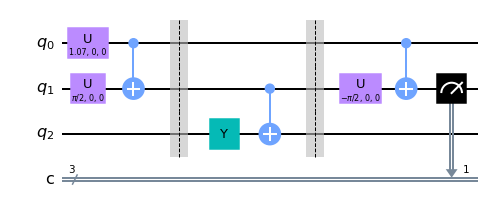

In [52]:
# visualize the sturcture
from qiskit import QuantumCircuit
n_qubits = 3

qc = QuantumCircuit(n_qubits, 3)
def first_order_neuron(input_x, theta, n_qubits):
    #qc = QuantumCircuit(n_qubits, 3)
    
    # encode the data x in the 0th wire
    qc.u(input_x, 0,0,0)
    
    qc.u(theta,0,0,1) # equivalent to the R(theta), but how to connect to the first wire, using a cx gate ?
    qc.cx(0,1)
    qc.barrier()
    
    qc.y(2) # how to code iY gate ?
    qc.cx(1,2)
    qc.barrier()
    
    qc.u(-theta,0,0,1)
    qc.cx(0,1)
    
    memory = [0,1,2]
    qc.measure([1], [memory[1]]) # measure to qubit n to classical bit m
    
    
print(train_angles[0][0][0])
# sometimes train_angles[0][0] is a scalar, and sometimes it's a vector
# if directly extract, it's a scalar.
first_order_neuron(train_angles[0][0][0],np.pi/2, 3)
qc.draw() # must be draw globally

In [55]:
# if the above sturcture is correct
# implement it in the following class template
class first_order_neuron:
    """ 
    This class provides a simple interface for interaction 
    with the quantum circuit 
    """
    
    def __init__(self, input_x, n_qubits, backend, shots):
        # --- Circuit definition ---
        self._circuit = qiskit.QuantumCircuit(n_qubits, 3) #QuantumCircuit(n_qubits)
        
        all_qubits = [i for i in range(n_qubits)]
        self.theta = qiskit.circuit.Parameter('theta')
        
        # ---------------------------
        #print(input_x)
        
        input_x = float(input_x)
        print(type(input_x))
        self._circuit.u(input_x, 0,0,0)
        self._circuit.barrier()
    
        self._circuit.u(self.theta,0,0,1) # equivalent to the R(theta), but how to connect to the first wire, using a cx gate ?
        self._circuit.cx(0,1)
        self._circuit.barrier()

        self._circuit.y(2) # how to code iY gate ?
        self._circuit.cx(1,2)
        self._circuit.barrier()

        self._circuit.u(-self.theta,0,0,1)
        self._circuit.cx(0,1)

        memory = [0,1,2]
        self._circuit.measure([1], [memory[1]]) # measure to qubit n to classical bit m
        
        # ---------------------------

        self.backend = backend
        self.shots = shots
    
    def run(self, thetas):
        t_qc = transpile(self._circuit,
                         self.backend)
        qobj = assemble(t_qc,
                        shots=self.shots,
                        parameter_binds = [{self.theta: theta} for theta in thetas])
        job = self.backend.run(qobj)
        result = job.result().get_counts()
        
        counts = np.array(list(result.values()))
        states = np.array(list(result.keys())).astype(float)
        
        # Compute probabilities for each state
        probabilities = counts / self.shots
        # Get state expectation
        
        print("the state: ",states)
        
        expectation = np.sum(states * probabilities)
        
        print("the expectation: ",expectation)
        
        return np.array([expectation])
print("hih")

hih


ModuleNotFoundError: No module named 'pennylane'

1.0668197
<class 'float'>
the state:  [0.]
the expectation:  0.0
Expected value for rotation pi 0.0
succeed


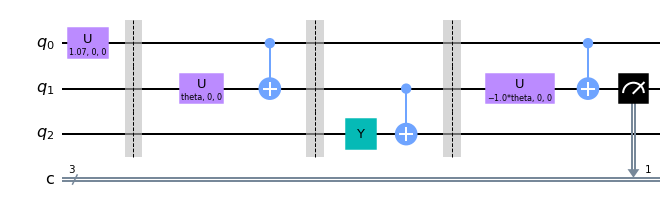

In [58]:
%tb
n_qubits, shots = 3, 100
backend = qiskit.Aer.get_backend('aer_simulator')
print(train_angles[0][0][0])
fon = first_order_neuron(train_angles[0][0][0], n_qubits, backend, shots)

print('Expected value for rotation pi {}'.format(fon.run([np.pi])[0]))
print("succeed")
fon._circuit.draw()


In [59]:
class HybridFunction(Function):
    """ Hybrid quantum - classical function definition """
    
    @staticmethod
    def forward(ctx, input, quantum_circuit, shift):
        """ Forward pass computation """
        ctx.shift = shift
        ctx.quantum_circuit = quantum_circuit

        expectation_z = ctx.quantum_circuit.run(input[0].tolist())
        result = torch.tensor([expectation_z])
        ctx.save_for_backward(input, result)

        return result
        
    @staticmethod
    def backward(ctx, grad_output):
        """ Backward pass computation """
        input, expectation_z = ctx.saved_tensors
        input_list = np.array(input.tolist())
        
        shift_right = input_list + np.ones(input_list.shape) * ctx.shift
        shift_left = input_list - np.ones(input_list.shape) * ctx.shift
        
        gradients = []
        for i in range(len(input_list)):
            expectation_right = ctx.quantum_circuit.run(shift_right[i])
            expectation_left  = ctx.quantum_circuit.run(shift_left[i])
            
            gradient = torch.tensor([expectation_right]) - torch.tensor([expectation_left])
            gradients.append(gradient)
        gradients = np.array([gradients]).T
        return torch.tensor([gradients]).float() * grad_output.float(), None, None

class Hybrid(nn.Module):
    """ Hybrid quantum - classical layer definition """
    
    def __init__(self, backend, shots, shift):
        super(Hybrid, self).__init__()
        self.quantum_circuit = first_order_neuron(train_angles[0][0][0], n_qubits, backend, shots)
        self.shift = shift
        
    def forward(self, input):
        return HybridFunction.apply(input, self.quantum_circuit, self.shift)

In [60]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, kernel_size=5)
        self.conv2 = nn.Conv2d(6, 16, kernel_size=5)
        self.dropout = nn.Dropout2d()
        self.fc1 = nn.Linear(256, 64)
        self.fc2 = nn.Linear(64, 1)
        self.hybrid = Hybrid(qiskit.Aer.get_backend('aer_simulator'), 100, np.pi / 2)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2)
        x = self.dropout(x)
        x = x.view(1, -1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        x = self.hybrid(x)
        return torch.cat((x, 1 - x), -1)

In [61]:
model = Net()
optimizer = optim.Adam(model.parameters(), lr=0.001)
loss_func = nn.NLLLoss()

epochs = 20
loss_list = []

model.train()
for epoch in range(epochs):
    total_loss = []
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()
        # Forward pass
        output = model(data)
        # Calculating loss
        loss = loss_func(output, target)
        # Backward pass
        loss.backward()
        # Optimize the weights
        optimizer.step()
        
        total_loss.append(loss.item())
    loss_list.append(sum(total_loss)/len(total_loss))
    print('Training [{:.0f}%]\tLoss: {:.4f}'.format(
        100. * (epoch + 1) / epochs, loss_list[-1]))

<class 'float'>
Traceback (most recent call last):
  Input In [61] in <cell line: 9>
    for batch_idx, (data, target) in enumerate(train_loader):
NameError: name 'train_loader' is not defined

Use %tb to get the full traceback.


(3) Input the angle into Displacement gate
===========================
Input the angle into Displacement gate, to eventually integrate our features to the circuit. \
Reference of the Displacement gate: https://docs.pennylane.ai/en/stable/code/api/pennylane.Displacement.html \
Our current circuit is the one in "Rapid training of QRNN". Displacement gate is the D gate in the following figure. \
The I gate in the figure has been modeled by Luis into combination of basis gates (which can be found in the APIs in Pennylane). So we can first implement the circuit. Because Pennylane and Xanadu are proposed by the same company, we think that it will be smooth to run the code on Xanadu, after running on LocalSimulator.

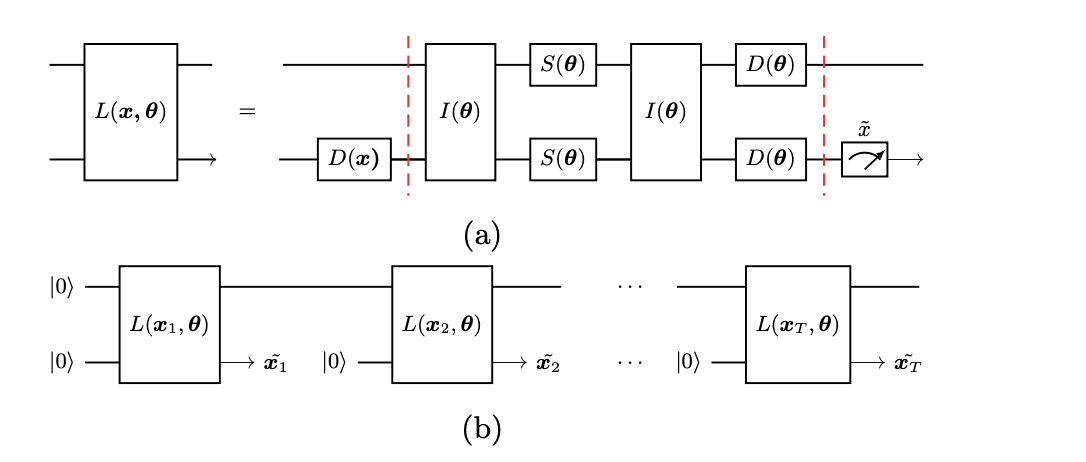

In [13]:
import pennylane as qml
import pennylane.numpy as pnp
from pennylane.optimize import NesterovMomentumOptimizer
from pennylane.optimize import AdamOptimizer
import strawberryfields as sf

Traceback (most recent call last):
  Input In [13] in <cell line: 1>
    import pennylane as qml
ModuleNotFoundError: No module named 'pennylane'

Use %tb to get the full traceback.


In [ ]:
n_wires = 2
dev_default = qml.device("default.qubit", wires=n_wires)
#dev = qml.device('strawberryfields.fock', wires=2, cutoff_dim=10)
dev = qml.device("default.gaussian", wires=n_wires)

Variational classifiers usually define a "layer" or "block", which is an
elementary circuit architecture that gets repeated to build the
variational circuit.

Our circuit layer consists of an arbitrary rotation on every qubit, as
well as CNOTs that entangle each qubit with its neighbour.


In [ ]:
def I_gate(theta):
    qml.Beamsplitter(theta, 3.14/2, wires=[0,1])
    qml.Squeezing(1, theta, wires=0)
    qml.Squeezing(1, theta, wires=1)
    qml.Rotation(theta, wires=0)
    qml.Rotation(theta, wires=1)
    qml.Beamsplitter(theta, 3.14/2, wires=[0,1])
    
def layer(x, theta):
    # encoding
    qml.Displacement(1, x, wires=1)
    
    # interaction, every component has a different parameter
    I_gate(theta[0])
    qml.Squeezing(1, theta[1], wires=0)
    qml.Squeezing(1, theta[2], wires=1)
    
    I_gate(theta[3])
    qml.Displacement(1, theta[4], wires=0)
    qml.Displacement(1, theta[5], wires=1)


In [ ]:
@qml.qnode(dev)
def circuit(weights, x):
    for i in range(len(weights)):
        layer(x[i], weights[i])
    return qml.expval(qml.X(wires=1)) # We were measuring the wrong wire

In [ ]:
depth = 1
combs = itertools.combinations(range(n_wires), 2)
def ansatz_qaoa(params):
    """VQC ansatz using single-qubits unitaries and entangling gates

    Args:
        params : shape (`depth` + 1, `n_wires`, 3) tensor containing trainable parameters
    """
    for m in range(depth + 1):
        for i in range(n_wires):
            qml.Rot(params[m, i, 0], params[m, i, 1], params[m, i, 2], wires=i)
        if m != depth:
            for s in combs:
                qml.CZ(wires=s)

@qml.qnode(dev_default)
def circuit_qaoa(weights, x):
    ansatz_qaoa(weights)
    return qml.expval(qml.PauliZ(wires=1))

In [ ]:
pnp.random.seed(0)
num_qubits = 2
num_layers = 1
weights_init = 0.01 * pnp.random.randn(1, 6, 1, requires_grad=True)
weights_init_qaoa = 2 * np.pi * pnp.random.randn(depth + 1, n_wires, 3, requires_grad=True)

In [ ]:
print(weights_init_qaoa.shape)

In [ ]:
def square_loss(labels, predictions):
    loss = 0
    for l, p in zip(labels, predictions):
        loss = loss + (labels - p) ** 2
    loss = pnp.mean(loss)
    return loss

In [ ]:
# https://pennylane.ai/qml/demos/spsa.html
costs = []
# Do you want to use the qaoa algorithm or the continuous variable device?
use_qaoa = True
def cost_spsa(weights):
    batch_inds = [pnp.random.randint(train_angles.shape[0], size=1)]
    # should be in [0, 1]?
    X = train_angles[batch_inds, 0:1]
    if use_qaoa:
        weights = weights.reshape(weights_init_qaoa.shape)
        predictions = [circuit_qaoa(weights, x) for x in X]
    else:
        weights = weights.reshape(weights_init.shape)
        predictions = [circuit(weights, x) for x in X]
    return square_loss(train_angles_y[batch_inds, 0:1], 
                       predictions)

iteration_num = 0
init_exe_count = int(dev.num_executions)
def callback_fn(w):
    global iteration_num
    num_executions = int(dev.num_executions) - init_exe_count

    iteration_num += 1
    if iteration_num % 10 == 0:
        cost_val = cost_spsa(w)
        costs.append(cost_val)

        print(
            f"Iteration = {iteration_num}, "
            f"Number of device executions = {num_executions}, "
            f"Cost = {cost_val}"
        )

init_w = weights_init_qaoa if use_qaoa else weights_init
res = minimizeSPSA(
    cost_spsa,
    x0=init_w.flatten().copy(),
    niter=200,
    paired=False,
    #c=0.01,
    #a=0.002,
    c = .02,
    a = .1,
    callback=callback_fn,
)

end
==============